# Analyzing the model comparison benchmark with ROC analysis

We want to analyze our model comparison benchmark with respect to the receiver operating characteristic and precision-recall curves.

For most models, we use thresholding on the p-values to create the curves.
Exceptions:
- scCODA: Use inclusion probability instead of p-values
- simple DM: No good way of building a ROC. Leave out!
- ANCOM: Use the W statistic (no. of significant tests for each cell type). There are not that many points here, since W is discrete from 0 to K.
Therefore, this is only partially informative.

For fairness reasons, we exclude the one-sample case from the analysis (many models are not applicable for this case.)

In [1]:
# Setup
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle as pkl

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

## Data preparation

**reading data**

In [2]:

# Read data. scCODA and simple DM results are stored in multiple files, therefore read them separately.
save_path = "../../zenodo_data_rv1/sccoda_benchmark_data/model_comparison/"

all_results = pd.read_csv(save_path + "benchmark_results")

In [3]:
all_effects = {}

for mod in pd.unique(all_results["model"]):
    with open(save_path + f"{mod}_effects", "rb") as f:
        eff = pd.read_csv(f)

    all_effects[mod] = eff

**scCODA**

First, we read in all inclusion probabilities from all cell types of all benchmark runs, and put them into a DataFrame.
We then add the ground truth value (1: expected change/0: no expected change) to each entry.

In [4]:
all_inc_probs_df = all_effects["scCODA"]
res = all_results[all_results["model"] == "scCODA"].reset_index()

count = 0
for i in range(len(res)):
    K = res.loc[i, "n_cell_types"]
    effect = eval(res.loc[i, "Increase"])
    n_samples = res.loc[i, "n_controls"]

    all_inc_probs_df.loc[count:count+K-1, "sample size"] = n_samples
    all_inc_probs_df.loc[count:count+K-1, "effect_0"] = effect[0]
    all_inc_probs_df.loc[count:count+K-1, "effect_1"] = effect[1]

    count += K

all_inc_probs_df["Ground truth"] = 0
all_inc_probs_df.loc[(all_inc_probs_df["Cell Type"] == 0) & (all_inc_probs_df["effect_0"] != 0), "Ground truth"] = 1
all_inc_probs_df.loc[(all_inc_probs_df["Cell Type"] == 1) & (all_inc_probs_df["effect_1"] != 0), "Ground truth"] = 1

We then calculate the ROC metrics (FPR, TPR, Precision, Recall) for all possible threshold values with the help of sklearn.
We also calculate the AUC and average precision score.

In [5]:
fprs = {}
tprs = {}
roc_aucs = {}
# exclude one-sample case
aip_2 = all_inc_probs_df.loc[all_inc_probs_df["sample size"] > 1 ,:]

fprs["scCODA_rev"], tprs["scCODA_rev"], thresh_2 = roc_curve(aip_2["Ground truth"], aip_2["Inclusion probability"])
roc_aucs["scCODA_rev"] = auc(fprs["scCODA_rev"], tprs["scCODA_rev"])

prec = {}
rec = {}
pr_aucs = {}

prec["scCODA_rev"], rec["scCODA_rev"], thresh_2_ = precision_recall_curve(aip_2["Ground truth"], aip_2["Inclusion probability"])
pr_aucs["scCODA_rev"] = average_precision_score(aip_2["Ground truth"], aip_2["Inclusion probability"])

print(roc_aucs)

{'scCODA_rev': 0.9883604529774872}


**scDC**

For the scDC model, we first have to concatenate all results and do some renaming to get the result in line with the other p-value based models

In [6]:
all_p_df = all_effects["scdc"]
res = all_results[all_results["model"] == "scdc"].reset_index()

count = 0
for i in range(len(res)):
    K = res.loc[i, "n_cell_types"]
    effect = eval(res.loc[i, "Increase"])
    n_samples = res.loc[i, "n_controls"]

    all_p_df.loc[count:count+K-1, "sample size"] = n_samples
    all_p_df.loc[count:count+K-1, "effect_0"] = effect[0]
    all_p_df.loc[count:count+K-1, "effect_1"] = effect[1]
    all_p_df.loc[count:count+K-1, "Cell Type"] = np.arange(K)

    count += K

all_p_df["Ground truth"] = 0
all_p_df.loc[(all_p_df["Cell Type"] == 0) & (all_p_df["effect_0"] != 0), "Ground truth"] = 1
all_p_df.loc[(all_p_df["Cell Type"] == 1) & (all_p_df["effect_1"] != 0), "Ground truth"] = 1
all_p_df.loc[all_p_df["p.value"] == 0, "p.value"] = 1
all_p_df["1-p"] = (1 - all_p_df["p.value"]).replace(np.nan, 0)

aip_2_scdc = all_p_df.loc[all_p_df["sample size"] > 1 ,:]

fprs["scdc"], tprs["scdc"], thresh_2 = roc_curve(aip_2_scdc["Ground truth"], aip_2_scdc["1-p"])
roc_aucs["scdc"] = auc(fprs["scdc"], tprs["scdc"])
prec["scdc"], rec["scdc"], thresh_2_ = precision_recall_curve(aip_2_scdc["Ground truth"], aip_2_scdc["1-p"])
pr_aucs["scdc"] = average_precision_score(aip_2_scdc["Ground truth"], aip_2_scdc["1-p"])

print(roc_aucs)

{'scCODA_rev': 0.9883604529774872, 'scdc': 0.5634062197409828}


**p-values**

For the p-values, the preparation is identical: Read p-values, determine ground truth, calculate statistics


ALDEx2_alr
ANCOMBC_holm
alr_ttest
alr_wilcoxon
dirichreg
Poisson_1e-10
ttest
BetaBinomial
{'scCODA_rev': 0.9883604529774872, 'scdc': 0.5634062197409828, 'ALDEx2_alr': 0.898558422597434, 'ANCOMBC_holm': 0.9371683800835149, 'alr_ttest': 0.9512793512466715, 'alr_wilcoxon': 0.9290646559549746, 'dirichreg': 0.6984388616557735, 'Poisson_1e-10': 0.43584140870854515, 'ttest': 0.844053346647301, 'BetaBinomial': 0.8375013238320018}


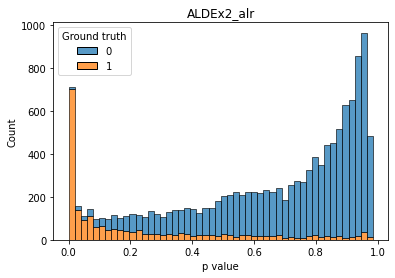

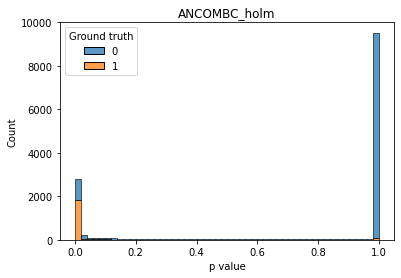

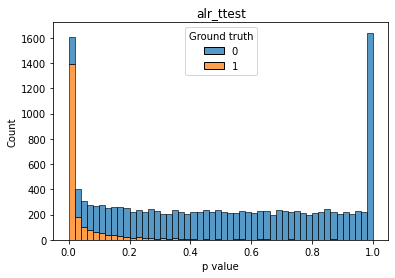

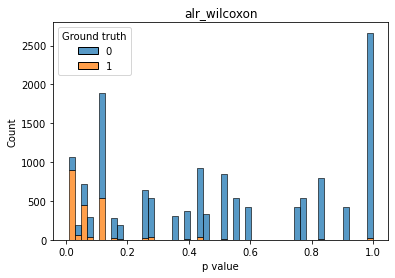

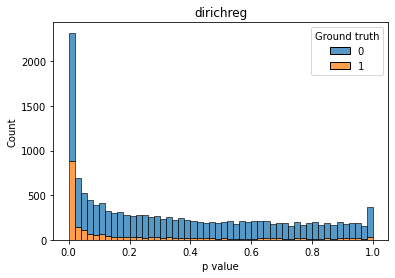

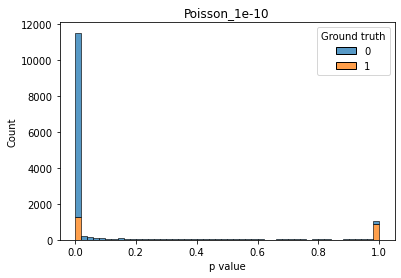

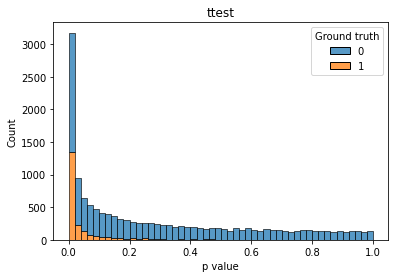

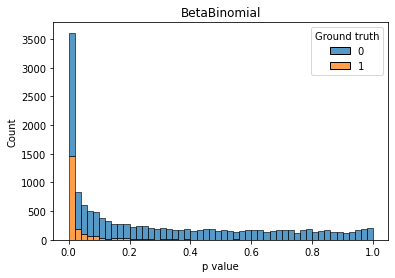

In [7]:
tests = ["ALDEx2_alr", "ANCOMBC_holm", "alr_ttest", "alr_wilcoxon", "dirichreg", "Poisson_1e-10", "ttest", "BetaBinomial"]

for test_name in tests:
    print(test_name)

    pval = all_effects[test_name]
    res = all_results[all_results["model"] == test_name].reset_index()

    count = 0
    for i in range(len(res)):
        K = res.loc[i, "n_cell_types"]
        effect = eval(res.loc[i, "Increase"])
        n_samples = res.loc[i, "n_controls"]

        pval.loc[count:count+K-1, "sample size"] = n_samples
        pval.loc[count:count+K-1, "effect_0"] = effect[0]
        pval.loc[count:count+K-1, "effect_1"] = effect[1]
        pval.loc[count:count+K-1, "Cell Type"] = np.arange(K)

        count += K

    pval["Ground truth"] = 0
    pval.loc[(pval["Cell Type"] == 0) & (pval["effect_0"] != 0), "Ground truth"] = 1
    pval.loc[(pval["Cell Type"] == 1) & (pval["effect_1"] != 0), "Ground truth"] = 1
    pval.loc[pval["p value"] == 0, "p value"] = 1
    pval["1-p"] = (1 - pval["p value"]).replace(np.nan, 0)

    pval_2 = pval.loc[pval["sample size"] > 1 ,:]

    fprs[test_name], tprs[test_name], thresh_2 = roc_curve(pval_2["Ground truth"], pval_2["1-p"])
    roc_aucs[test_name] = auc(fprs[test_name], tprs[test_name])
    prec[test_name], rec[test_name], thresh_2_ = precision_recall_curve(pval_2["Ground truth"], pval_2["1-p"])
    pr_aucs[test_name] = average_precision_score(pval_2["Ground truth"], pval_2["1-p"])

    # Histograms of ground truth for p-values
    sns.histplot(data=pval_2,
                 x="p value",
                 bins=50,
                 hue="Ground truth",
                 multiple="stack")
    plt.title(test_name)
    plt.show()

print(roc_aucs)

**ANCOM**

For ANCOM, we need to extract the W statistic. Then the procedure is identical

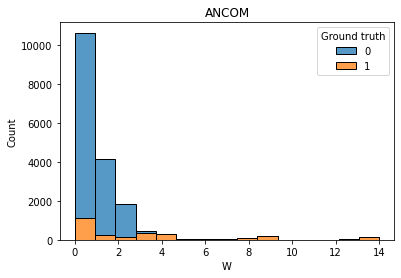

{'scCODA_rev': 0.9883604529774872, 'scdc': 0.5634062197409828, 'ALDEx2_alr': 0.898558422597434, 'ANCOMBC_holm': 0.9371683800835149, 'alr_ttest': 0.9512793512466715, 'alr_wilcoxon': 0.9290646559549746, 'dirichreg': 0.6984388616557735, 'Poisson_1e-10': 0.43584140870854515, 'ttest': 0.844053346647301, 'BetaBinomial': 0.8375013238320018, 'ANCOM': 0.7722988531832486}


In [8]:
w_df = all_effects["ancom"]
res = all_results[all_results["model"] == "ancom"].reset_index()

# Get all p-values
w_df = w_df.rename(columns={"Unnamed: 0": "Cell Type"})

count = 0
for i in range(len(res)):
    K = res.loc[i, "n_cell_types"]
    effect = eval(res.loc[i, "Increase"])
    n_samples = res.loc[i, "n_controls"]

    w_df.loc[count:count+K-1, "sample size"] = n_samples
    w_df.loc[count:count+K-1, "effect_0"] = effect[0]
    w_df.loc[count:count+K-1, "effect_1"] = effect[1]
    w_df.loc[count:count+K-1, "Cell Type"] = np.arange(K)

    count += K

w_df["Ground truth"] = 0
w_df.loc[(w_df["Cell Type"] == 0) & (w_df["effect_0"] != 0), "Ground truth"] = 1
w_df.loc[(w_df["Cell Type"] == 1) & (w_df["effect_1"] != 0), "Ground truth"] = 1

w_df_2 = w_df.loc[w_df["sample size"] > 1 ,:]

fprs["ANCOM"], tprs["ANCOM"], thresh_2 = roc_curve(w_df_2["Ground truth"], w_df_2["W"])
roc_aucs["ANCOM"] = auc(fprs["ANCOM"], tprs["ANCOM"])
prec["ANCOM"], rec["ANCOM"], thresh_2_ = precision_recall_curve(w_df_2["Ground truth"], w_df_2["W"])
pr_aucs["ANCOM"] = average_precision_score(w_df_2["Ground truth"], w_df_2["W"])

# Histograms of ground truth for p-values
sns.histplot(data=w_df,
             x="W",
             bins=15,
             hue="Ground truth",
             multiple="stack")
plt.title("ANCOM")
plt.show()

print(roc_aucs)


## Analysis

### ROC plot

In [9]:
models = list(roc_aucs.keys())
print(models)

models_rel = ["scCODA_rev", "ANCOM", "ALDEx2_alr", "ANCOMBC_holm", "alr_ttest", "alr_wilcoxon", "dirichreg", "scdc", "Poisson_1e-10", "ttest", "BetaBinomial"]

linestyles = dict(zip(models_rel, [0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 3]))
colors = dict(zip(models_rel, [0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3]))

dashes=[(1,0), (4, 4), (7, 2, 2, 2), (2, 2, 2, 2, 4, 2)]
palette = sns.color_palette(['#e41a1c','#377eb8','#4daf4a','#984ea3'])

# Nice label names for legend
leg_labels = ["scCODA", "ANCOM", "ALDEx2", "ANCOMBC",
              "ALR + t", "ALR + Wilcoxon", "Dirichlet regression", "scDC", "Poisson regression", "t-test", "BetaBinomial"]
lab = dict(zip(models_rel, leg_labels))

plot_path = "../../sccoda_benchmark_data/paper_plots_rv1/model_comparison_v3"

['scCODA_rev', 'scdc', 'ALDEx2_alr', 'ANCOMBC_holm', 'alr_ttest', 'alr_wilcoxon', 'dirichreg', 'Poisson_1e-10', 'ttest', 'BetaBinomial', 'ANCOM']


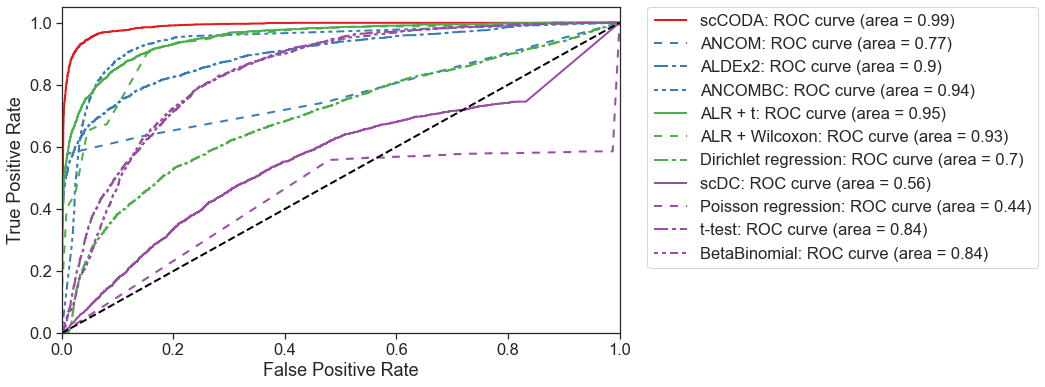

In [10]:
sns.set(style="ticks", font_scale=1.5)

plt.figure(figsize=(10,6))
lw = 2
for m in models_rel:
    plt.plot(
        fprs[m],
        tprs[m],
        color=palette[colors[m]],
        lw=lw,
        label=f'{lab[m]}: ROC curve (area = {np.round(roc_aucs[m], 2)})',
        dashes=dashes[linestyles[m]]
    )
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.savefig(plot_path + "/model_comparison_roc.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "/model_comparison_roc.png", format="png", bbox_inches="tight")

plt.show()

### Precision-Recall plot

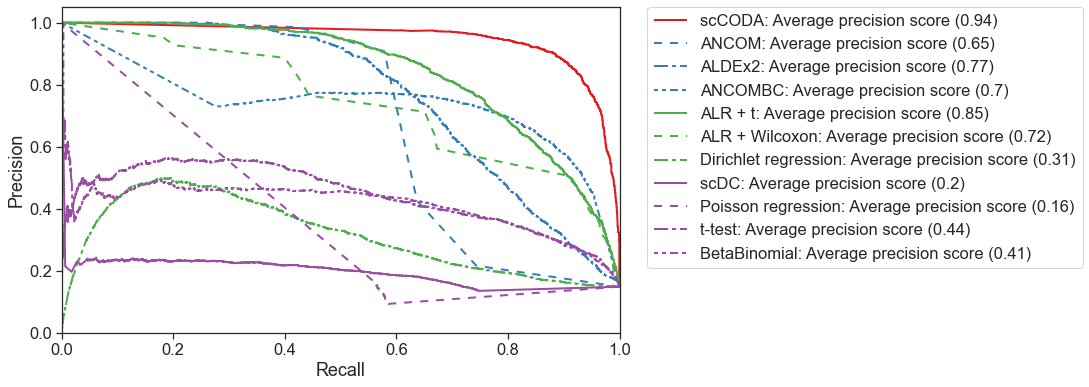

In [11]:
sns.set(style="ticks", font_scale=1.5)

plt.figure(figsize=(10,6))
lw = 2
for m in models_rel:
    plt.plot(
        rec[m],
        prec[m],
        color=palette[colors[m]],
        lw=lw,
        label=f'{lab[m]}: Average precision score ({np.round(pr_aucs[m], 2)})',
        dashes=dashes[linestyles[m]]
    )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.savefig(plot_path + "/model_comparison_prc.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "/model_comparison_prc.png", format="png", bbox_inches="tight")

plt.show()

